# Plotting notebook for the paper "Safe and Efficient Model-free Adaptive Control via Bayesian Optimization"

In [2]:
#

import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from pathlib import Path
from utils import *

%matplotlib inline

# Comparison to CBO
Here we plot the comparison to CBO, i.e., fig 3 in the paper.

In [3]:
# Define directories to load and save
BASE_DIR = Path().resolve().parent.parent
PLOTS_DIR = Path("./comparison_with_CBO/")
PLOTS_DIR.mkdir(exist_ok=True)

mat = scipy.io.loadmat(BASE_DIR.joinpath('GoOSECBOcomp_sim_computed_new.mat'))
cbo = np.squeeze(mat['CBO'])
goose = np.squeeze(mat['GoOSE'])

/Users/matteoturchetta/anaconda/lib/python3.6/site-packages/scipy/io/matlab/mio.py:218: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


In [3]:
def unpack(data):
    """Utility to automatically unpack the .mat files"""
    n_trials = len(data)
    n_steps = data[0][1].size
    controllers = np.zeros((n_trials, n_steps, 3), dtype=float)
    objective = np.zeros((n_trials, n_steps, 1), dtype=float)
    constraints = np.zeros((n_trials, n_steps, 2), dtype=float)
    
    for i in range(n_trials):
        controllers[i, :, :] = data[i][0][:]
        objective[i, :, :] = data[i][1][:]
        constraints[i, :, :] = data[i][2][:]
    return controllers, objective, constraints
        

x_cbo, f_cbo, q_cbo = unpack(cbo)
x_goo, f_goo, q_goo = unpack(goose)


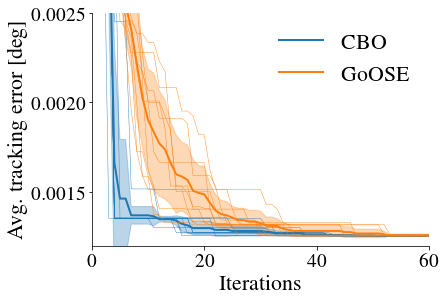

In [4]:
# Cost convergence plot

iterations = np.arange(1, 1+f_cbo[0].size)
set_figure_params(fontsize=22)
for f, label, c in zip([f_cbo, f_goo], ['CBO', 'GoOSE'], ['tab:blue', 'tab:orange']):
    f_tmp = np.minimum.accumulate(f, axis=1)
    mu = f_tmp.mean(axis=0)[:, 0]
    std = f_tmp.std(axis=0)[:, 0]
    for f_run in f_tmp:
        plt.plot(iterations, f_run, lw=0.4, c=c)
    plt.plot(iterations, mu, label=label, c=c, lw=2)
    plt.fill_between(iterations, mu - std, mu + std, color=c, alpha=0.3)
plt.legend(frameon=False)
hide_all_ticks(plt.gca())
hide_spines(plt.gca())
plt.ylim([0.0012, 0.0025])
plt.xlim([0, 60])


plt.xlabel('Iterations')
plt.ylabel('Avg. tracking error [deg]')
plt.tight_layout(pad=0.01)

plt.savefig(PLOTS_DIR.joinpath('objective.pdf'), format='pdf', transparent=True)


In [5]:
def split_hist(y1, y2, bins1=None, bins2=None, xlim1=None, xlim2=None, axes=None, color='tab:blue', label='', alpha=1, remove_axis=True):
    """Utility to plot split histograms"""
    if axes is None:
        f, (ax, ax2) = plt.subplots(1, 2, sharey=True)
    else:
        ax, ax2 = axes

    ax.hist(y1, bins=bins1, color=color, alpha=alpha)
    ax2.hist(y2, bins=bins2, color=color, label=label, alpha=alpha)

    ax.set_xlim(*xlim1)  # outliers only
    ax2.set_xlim(*xlim2)  # most of the data

    ax.spines['right'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax2.xaxis.tick_bottom()
    ax2.yaxis.tick_right()

    d = .02  # how big to make the diagonal lines in axes coordinates
    
    if remove_axis:
        ax.spines['top'].set_visible(False)
        ax2.spines['top'].set_visible(False)
        ax2.spines['right'].set_visible(False)
        plt.tick_params(axis = "y", which = "both", left = False, right = False)
        
        # arguments to pass to plot, just so we don't keep repeating them
        kwargs = dict(transform=ax.transAxes, color='k', clip_on=False, lw=0.8)
        ax.plot((1-d, 1+d), (-d, +d), **kwargs)        # top-left diagonal
#         ax.plot((1 - d, 1 + d), (1-d, 1+d), **kwargs)  # top-right diagonal

        kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
        ax2.plot((-d, +d), (-d, +d), **kwargs)  # bottom-left diagonal
#         ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal
        
    else:

        # arguments to pass to plot, just so we don't keep repeating them
        kwargs = dict(transform=ax.transAxes, color='k', clip_on=False, lw=0.8)
        ax.plot((1-d, 1+d), (-d, +d), **kwargs)        # top-left diagonal
        ax.plot((1 - d, 1 + d), (1-d, 1+d), **kwargs)  # top-right diagonal

        kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
        ax2.plot((-d, +d), (-d, +d), **kwargs)  # bottom-left diagonal
        ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal
    

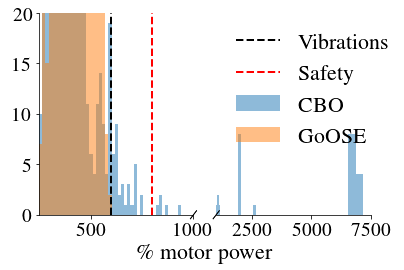

In [6]:
# Plot safety constraint comparison
f, axes = plt.subplots(1, 2, sharey=True)

for q, label, color in zip([q_cbo, q_goo], ['CBO', 'GoOSE'], ['tab:blue', 'tab:orange']):
    q_tmp = q[:, :, 0].ravel()
    
    bins1 = np.linspace(250, 1000, 50)
    bins2 = np.logspace(3, 4, 50)

    q_low = q_tmp[q_tmp < 1000]
    q_high = q_tmp[q_tmp >= 1000]
    q_high = np.clip(q_high, -np.inf, 7000)
    split_hist(q_low, q_high, bins1, bins2, (250, 1000), (1000, 7500), label=label, alpha=0.5, axes=axes, color=color)
    
for ax in axes:
    ax.plot([600, 600], [0, 20], '--k', lw=2, label='Vibrations')
    ax.plot([800, 800], [0, 20], '--r', lw=2, label='Safety')
    

plt.ylim([0, 20])
plt.legend(frameon=False)

f.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel("\% motor power")


plt.tight_layout(pad=0.01)

plt.savefig(PLOTS_DIR.joinpath('safety_constraint.pdf'), format='pdf', transparent=True)



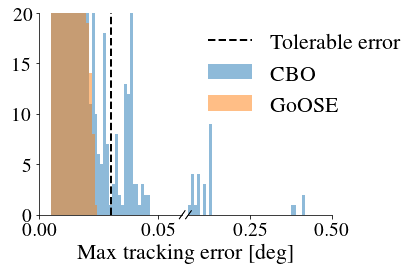

In [7]:
# Plot performance constraint comparison
f, axes = plt.subplots(1, 2, sharey=True)

for q, label, color in zip([q_cbo, q_goo], ['CBO', 'GoOSE'], ['tab:blue', 'tab:orange']):
    q_tmp = q[:, :, 1].ravel()
    threshold = 0.06
    bins1 = np.linspace(0, threshold, 50)
    bins2 = np.linspace(threshold, 0.5, 50)

    q_low = q_tmp[q_tmp < threshold]
    q_high = q_tmp[q_tmp >= threshold]
    
#     q_high = np.clip(q_high, -np.inf, 7000)
    split_hist(q_low, q_high, bins1, bins2, (0, threshold), (threshold, 0.5), label=label, alpha=0.5, axes=axes, color=color)
    
for ax in axes:
    ax.plot([0.03, 0.03], [0, 20], '--k', lw=2, label='Tolerable error')
    

plt.ylim([0, 20])
plt.legend(frameon=False)

f.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel("Max tracking error [deg]")

plt.tight_layout(pad=0.01)
plt.savefig(PLOTS_DIR.joinpath('performance_constraint.pdf'), format='pdf', transparent=True)



# Adaptive control simulation
Here we plot the results for the numerical experiments in the paper when the task parameter is modeled explicitly and when it is not modeled. We have three adaptation scenarios: feed forward gain (i.e. instant known change, not included in the paper), moment of inertia (i.e. instant change that must be inferred from data, fig 4 and 6 top in the paper), and drift in rotational damping coefficient (i.e. slow change modeled with time varying kernel, fig 4 and 6 bottom in the paper).

In [52]:
def unpack_adaptive_exp(data, increment = 0):
    """
    Utility to unpack data from adaptive control experiment stored in .mat file
    
    Parameters
    ----------
    data: output of scipy.io.loadmat
    increment: float
        Minimum increment in task parameter absolute difference to define a switch between tasks
    """
    task = data['samples_all'][:, -1]
    switches = np.ones_like(task, dtype=bool)
    switches[1:] = np.abs(task[1:] - task[:-1]) > increment
    
    cost = data['values_all']
    safety_const = data['con_values_all'][:, 0]
    performance_const = data['con_values_all'][:, 1]
    cost_per_task = []
    min_cost_per_task = []
    tmp = []
#     for j, v in enumerate(cost):
# #         print(type(v[0]))
#         if switches[j]:
#             if tmp:
#                 min_cost_per_task.append(np.minimum.accumulate(tmp))
#                 cost_per_task.append(tmp)
#             tmp = []
#         tmp.append(v[0])
#     min_cost_per_task.append(np.minimum.accumulate(tmp))
#     cost_per_task.append(tmp)
# #     print(min_cost_per_task)
#     min_cost = np.hstack(min_cost_per_task)
    min_cost = compute_min_cost(cost, switches)
    return task, switches, cost, cost_per_task, min_cost, safety_const, performance_const

def compute_min_cost(cost, switches):
    """
    Utility to compute running minimum for each task given the costs and the switches.
    """    
    cost_per_task = []
    min_cost_per_task = []
    tmp = []
    for j, v in enumerate(cost):
        if switches[j]:
            if tmp:
                min_cost_per_task.append(np.minimum.accumulate(tmp))
                cost_per_task.append(tmp)
            tmp = []
        tmp.append(v[0])
    min_cost_per_task.append(np.minimum.accumulate(tmp))
    cost_per_task.append(tmp)
    min_cost = np.hstack(min_cost_per_task)
    return min_cost
        

In [53]:
set_figure_params(fontsize=22)

def plot_with_task(x, y1, c1, label1, y2, c2, label2, lw1=1):
    """
    Utility to plot cost or contraint on left axis and task parameter on right axes.
    
    Parameters
    ----------
    x: np.array
        x values on the plot (iterations)
    y1: np.array
        y values for left axis
    c1: color specification
        Color of line on left axis
    label1: str
        Label line on left axis
    y2: np.array
        y values for right axis
    c2: color specification
        Color of line on right axis
    label2: str
        Label line on right axis
    lw1: int
        Line width of line on left axis
    """
    fig, ax1 = plt.subplots()

    l1 = ax1.plot(x, y1, color=c1, label=label1, lw=lw1)
    ax1.tick_params(axis='y', labelcolor=c1)
    ax1.spines['left'].set_color(c1)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    ax2.spines['right'].set_color(c2)
    l2 = ax2.plot(x, y2, '--', color=c2, alpha=0.8, label=label2)
    ax2.tick_params(axis='y', labelcolor=c2)
    ax1.tick_params(axis='y', labelcolor=c1)
    ax2.tick_params(axis='y', colors=c2)
    ax2.spines['left'].set_color(c1)
#     ax1.spines['top'].set_visible(False)
#     ax2.spines['top'].set_visible(False)

    return fig, (ax1, ax2), (l1, l2)

def unify_legend(ax1, lines, **kwargs):
    """
    Utility to put legends all on the same axes.
    """
    # added these three lines
    lines = [l for l in lines]
    labs = [l.get_label() for l in lines]
    ax1.legend(lines, labs, loc=2, frameon=False, **kwargs)



### Feed forward gain
Not included in the paper.

In [67]:
PLOTS_DIR = Path("./KFF_sim/")
PLOTS_DIR.mkdir(exist_ok=True)

kff_mat = mat = scipy.io.loadmat(BASE_DIR.joinpath('AdaptKff_sim.mat'))
task, switches, cost, cost_per_task, min_cost, safety_const, performance_const = unpack_adaptive_exp(kff_mat)


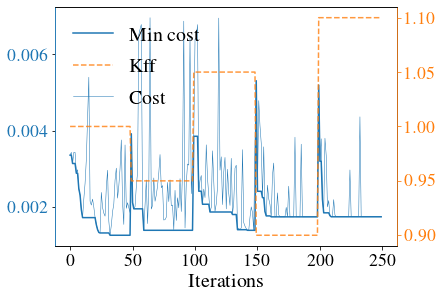

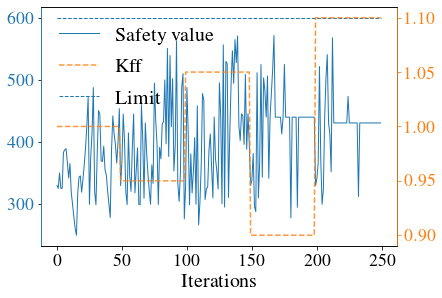

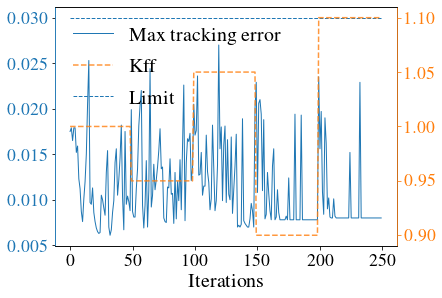

In [68]:
fig, (ax1, ax2), (l1, l2) = plot_with_task(np.arange(250), min_cost, 'tab:blue', 'Min cost', task, 'tab:orange', 'Kff', lw1=1.5)
l3 = ax1.plot(np.arange(250), cost, label='Cost', c='tab:blue', lw=0.5)
ax1.set_xlabel('Iterations')
unify_legend(ax1, l1+l2+l3)
plt.tight_layout(pad=0.1)
plt.savefig(PLOTS_DIR.joinpath('cost.pdf'), format='pdf', transparent=True)


fig, (ax1, ax2), (l1, l2) = plot_with_task(np.arange(250), safety_const, 'tab:blue', 'Safety value', task, 'tab:orange', 'Kff')
l3 = ax1.plot(np.full_like(safety_const, 600), '--', c='tab:blue', label='Limit', lw=1)
ax1.set_xlabel('Iterations')

unify_legend(ax1, l1+l2+l3)
plt.tight_layout(pad=0.1)
plt.savefig(PLOTS_DIR.joinpath('safety_constraint.pdf'), format='pdf', transparent=True)

fig, (ax1, ax2), (l1, l2) = plot_with_task(np.arange(250), performance_const, 'tab:blue', 'Max tracking error', task, 'tab:orange', 'Kff')
l3 = ax1.plot(np.full_like(safety_const, 0.03), '--', c='tab:blue', label='Limit', lw=1)
ax1.set_xlabel('Iterations')
unify_legend(ax1, l1+l2+l3)
plt.tight_layout(pad=0.1)
plt.savefig(PLOTS_DIR.joinpath('performance_constraint.pdf'), format='pdf', transparent=True)


### Moment of inertia
Figure 4 top in the paper.

In [69]:
PLOTS_DIR = Path("./M_sim/")
PLOTS_DIR.mkdir(exist_ok=True)

kff_mat = mat = scipy.io.loadmat(BASE_DIR.joinpath('Adaptm_sim.mat'))
task, switches, cost, cost_per_task, min_cost, safety_const, performance_const = unpack_adaptive_exp(kff_mat, increment=0.15)

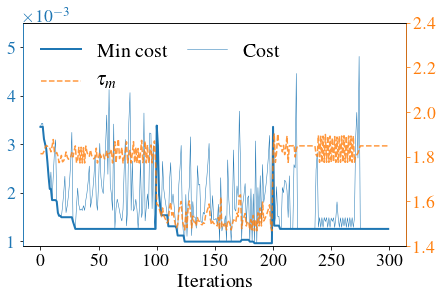

In [70]:
set_figure_params(fontsize=20)
legend_kwargs = dict(ncol=2, columnspacing=1.)

x = np.arange(cost.size)
ylim2 = [1.4, 2.4]
lw=2
fig, (ax1, ax2), (l1, l2) = plot_with_task(x, min_cost, 'tab:blue', 'Min cost', task, 'tab:orange', r'$\tau_m$', lw1=lw)
l3 = ax1.plot(x, cost, label='Cost', c='tab:blue', lw=0.5)
ax1.set_xlabel('Iterations')
ax1.set_ylim([0.0009, 0.0055])
ax1.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
ax2.set_ylim(ylim2)
unify_legend(ax1, l1+l2+l3, **legend_kwargs)
plt.tight_layout(pad=0.1)

plt.savefig(PLOTS_DIR.joinpath('cost.pdf'), format='pdf', transparent=True)


fig, (ax1, ax2), (l1, l2) = plot_with_task(x, safety_const, 'tab:blue', 'Safety value', task, 'tab:orange', r'$\tau_m$')
l3 = ax1.plot(np.full_like(safety_const, 600), '--', c='tab:blue', label='Limit', lw=1)
ax1.set_xlabel('Iterations')
ax1.set_ylim([280, 750])
ax1.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
ax2.set_ylim(ylim2)

unify_legend(ax1, l1+l2+l3, **legend_kwargs)
plt.tight_layout(pad=0.1)
plt.savefig(PLOTS_DIR.joinpath('safety_constraint.pdf'), format='pdf', transparent=True)

fig, (ax1, ax2), (l1, l2) = plot_with_task(x, performance_const, 'tab:blue', 'Max tracking error', task, 'tab:orange', r'$\tau_m$')
l3 = ax1.plot(np.full_like(safety_const, 0.03), '--', c='tab:blue', label='Limit', lw=1)
ax1.set_xlabel('Iterations')
ax1.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
ax1.set_ylim([0.005, 0.042])

ax2.set_ylim(ylim2)
unify_legend(ax1, l1+l2+l3, **legend_kwargs)
plt.tight_layout(pad=0.1)
plt.savefig(PLOTS_DIR.joinpath('performance_constraint.pdf'), format='pdf', transparent=True)

### Moment of inertia not modeled
Figure 6 top in the paper.

In [71]:
PLOTS_DIR = Path("./M_sim_no_task_param/")
PLOTS_DIR.mkdir(exist_ok=True)

kff_mat = mat = scipy.io.loadmat(BASE_DIR.joinpath('Notaskm_sim.mat'))
task, switches, cost, cost_per_task, min_cost, safety_const, performance_const = unpack_adaptive_exp(kff_mat, increment=0.15)

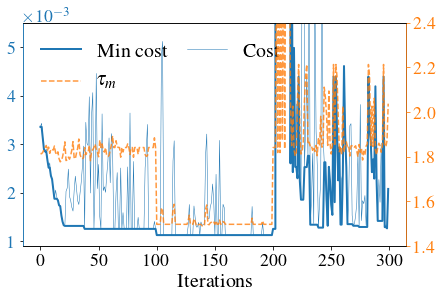

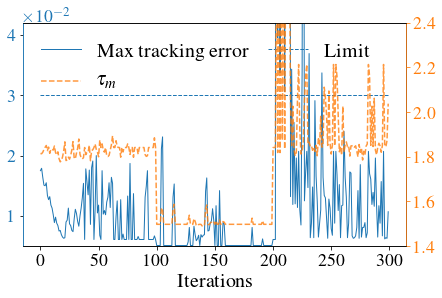

In [57]:
set_figure_params(fontsize=20)
legend_kwargs = dict(ncol=2, columnspacing=1.)

x = np.arange(cost.size)
ylim2 = [1.4, 2.4]
lw=2
fig, (ax1, ax2), (l1, l2) = plot_with_task(x, min_cost, 'tab:blue', 'Min cost', task, 'tab:orange', r'$\tau_m$', lw1=lw)
l3 = ax1.plot(x, cost, label='Cost', c='tab:blue', lw=0.5)
ax1.set_xlabel('Iterations')
ax1.set_ylim([0.0009, 0.0055])
ax1.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
ax2.set_ylim(ylim2)
unify_legend(ax1, l1+l2+l3, **legend_kwargs)
plt.tight_layout(pad=0.1)

plt.savefig(PLOTS_DIR.joinpath('cost.pdf'), format='pdf', transparent=True)


fig, (ax1, ax2), (l1, l2) = plot_with_task(x, safety_const, 'tab:blue', 'Safety value', task, 'tab:orange', r'$\tau_m$')
l3 = ax1.plot(np.full_like(safety_const, 600), '--', c='tab:blue', label='Limit', lw=1)
ax1.set_xlabel('Iterations')
ax1.set_ylim([280, 750])
ax1.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
ax2.set_ylim(ylim2)

unify_legend(ax1, l1+l2+l3, **legend_kwargs)
plt.tight_layout(pad=0.1)
plt.savefig(PLOTS_DIR.joinpath('safety_constraint.pdf'), format='pdf', transparent=True)

fig, (ax1, ax2), (l1, l2) = plot_with_task(x, performance_const, 'tab:blue', 'Max tracking error', task, 'tab:orange', r'$\tau_m$')
l3 = ax1.plot(np.full_like(safety_const, 0.03), '--', c='tab:blue', label='Limit', lw=1)
ax1.set_xlabel('Iterations')
ax1.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
ax1.set_ylim([0.005, 0.042])

ax2.set_ylim(ylim2)
unify_legend(ax1, l1+l2+l3, **legend_kwargs)
plt.tight_layout(pad=0.1)
plt.savefig(PLOTS_DIR.joinpath('performance_constraint.pdf'), format='pdf', transparent=True)

### Time varying B
Figure 4 bottom in the paper.

In [59]:
PLOTS_DIR = Path("./bvar_sim/")
PLOTS_DIR.mkdir(exist_ok=True)

kff_mat = mat = scipy.io.loadmat(BASE_DIR.joinpath('Adaptbvar_sim.mat'))
task, switches, cost, cost_per_task, min_cost, safety_const, performance_const = unpack_adaptive_exp(kff_mat, increment=0.15)

cost=kff_mat['values_all']
min_cost = kff_mat['glbest']
safety_const = kff_mat['con_values_all'][:, 0]
performance_const = kff_mat['con_values_all'][:, 1]


In [60]:
set_figure_params(fontsize=20)
legend_kwargs = dict(ncol=2, columnspacing=1.)

x = np.arange(cost.size)
ylim2 = [1.4, 2.4]
fig, (ax1, ax2), (l1, l2) = plot_with_task(x, min_cost, 'tab:blue', 'Min cost', task, 'tab:orange', r'$\tau_t$', lw1=lw)
l3 = ax1.plot(x, cost, label='Cost', c='tab:blue', lw=0.5)
ax1.set_xlabel('Iterations')
ax1.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
ax1.set_ylim([0.0009, 0.0055])
# ax2.set_ylim(ylim2)
unify_legend(ax1, l1+l2+l3, **legend_kwargs)
plt.tight_layout(pad=0.1)

plt.savefig(PLOTS_DIR.joinpath('cost.pdf'), format='pdf', transparent=True)


fig, (ax1, ax2), (l1, l2) = plot_with_task(x, safety_const, 'tab:blue', 'Safety value', task, 'tab:orange', r'$\tau_t$')
l3 = ax1.plot(np.full_like(safety_const, 600), '--', c='tab:blue', label='Limit', lw=1)
ax1.set_xlabel('Iterations')
ax1.set_ylim([280, 750])
ax1.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))

unify_legend(ax1, l1+l2+l3, **legend_kwargs)
plt.tight_layout(pad=0.1)
plt.savefig(PLOTS_DIR.joinpath('safety_constraint.pdf'), format='pdf', transparent=True)

fig, (ax1, ax2), (l1, l2) = plot_with_task(x, performance_const, 'tab:blue', 'Max tracking error', task, 'tab:orange', r'$\tau_t$')
l3 = ax1.plot(np.full_like(safety_const, 0.03), '--', c='tab:blue', label='Limit', lw=1)
ax1.set_xlabel('Iterations')
ax1.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
ax1.set_ylim([0.005, 0.042])
unify_legend(ax1, l1+l2+l3, **legend_kwargs)
plt.tight_layout(pad=0.1)
plt.savefig(PLOTS_DIR.joinpath('performance_constraint.pdf'), format='pdf', transparent=True)

### Time varying B not modeled
Figure 6 bottom in the paper.

In [61]:
PLOTS_DIR = Path("./bvar_sim_no_task_param/")
PLOTS_DIR.mkdir(exist_ok=True)

kff_mat = mat = scipy.io.loadmat(BASE_DIR.joinpath('Notaskbvar_sim.mat'))
task, switches, cost, cost_per_task, min_cost, safety_const, performance_const = unpack_adaptive_exp(kff_mat, increment=0.15)

# for k, v in kff_mat.items():
#     print(k)
# plt.plot(kff_mat['glbest'])
cost=kff_mat['values_all']
min_cost = kff_mat['glbest']
safety_const = kff_mat['con_values_all'][:, 0]
performance_const = kff_mat['con_values_all'][:, 1]

task = np.arange(300)



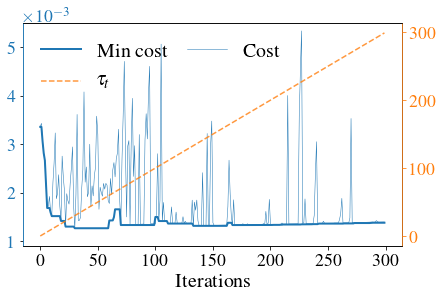

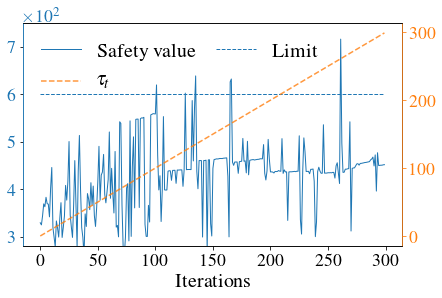

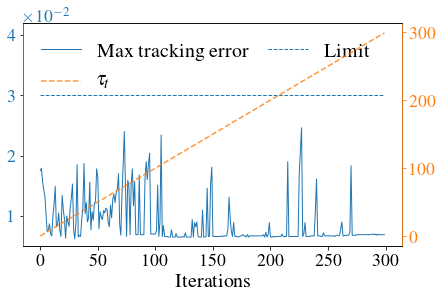

In [62]:
set_figure_params(fontsize=20)
legend_kwargs = dict(ncol=2, columnspacing=1.)

x = np.arange(cost.size)
ylim2 = [1.4, 2.4]
fig, (ax1, ax2), (l1, l2) = plot_with_task(x, min_cost, 'tab:blue', 'Min cost', task, 'tab:orange', r'$\tau_t$', lw1=lw)
l3 = ax1.plot(x, cost, label='Cost', c='tab:blue', lw=0.5)
ax1.set_xlabel('Iterations')
ax1.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
ax1.set_ylim([0.0009, 0.0055])
# ax2.set_ylim(ylim2)
unify_legend(ax1, l1+l2+l3, **legend_kwargs)
plt.tight_layout(pad=0.1)

plt.savefig(PLOTS_DIR.joinpath('cost.pdf'), format='pdf', transparent=True)


fig, (ax1, ax2), (l1, l2) = plot_with_task(x, safety_const, 'tab:blue', 'Safety value', task, 'tab:orange', r'$\tau_t$')
l3 = ax1.plot(np.full_like(safety_const, 600), '--', c='tab:blue', label='Limit', lw=1)
ax1.set_xlabel('Iterations')
ax1.set_ylim([280, 750])
ax1.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))

unify_legend(ax1, l1+l2+l3, **legend_kwargs)
plt.tight_layout(pad=0.1)
plt.savefig(PLOTS_DIR.joinpath('safety_constraint.pdf'), format='pdf', transparent=True)

fig, (ax1, ax2), (l1, l2) = plot_with_task(x, performance_const, 'tab:blue', 'Max tracking error', task, 'tab:orange', r'$\tau_t$')
l3 = ax1.plot(np.full_like(safety_const, 0.03), '--', c='tab:blue', label='Limit', lw=1)
ax1.set_xlabel('Iterations')
ax1.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
ax1.set_ylim([0.005, 0.042])
unify_legend(ax1, l1+l2+l3, **legend_kwargs)
plt.tight_layout(pad=0.1)
plt.savefig(PLOTS_DIR.joinpath('performance_constraint.pdf'), format='pdf', transparent=True)

# Adaptive control hardware
Here we plot the results for the hardware experiments in the paper when the task parameter is modeled explicitly and when it is not modeled. We have two adaptation scenarios: feed forward gain (i.e. instant known change, fig 5 top for modeled case and fig 7 for the unmodeled one), moment of inertia (i.e. instant change that must be inferred from data, fig 5 bottome for the unmodeled case, we do not have the unmodeled case due to safety concerns on the real platform).

### Feed forward gain
Figure 5 top in the paper.

In [63]:
PLOTS_DIR = Path("./KFF_exp/")
PLOTS_DIR.mkdir(exist_ok=True)

kff_mat = mat = scipy.io.loadmat(BASE_DIR.joinpath('AdaptKff_exp.mat'))
task, switches, cost, cost_per_task, min_cost, safety_const, performance_const = unpack_adaptive_exp(kff_mat)

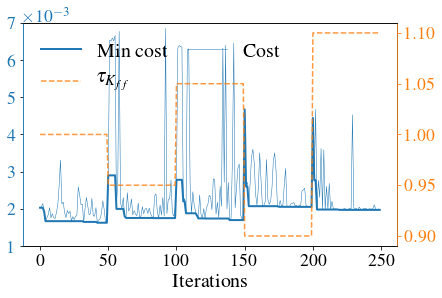

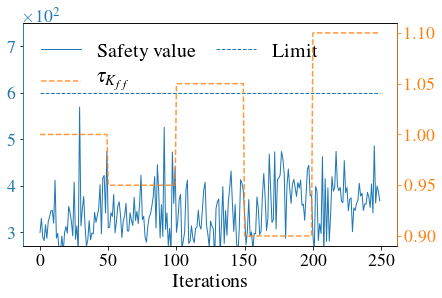

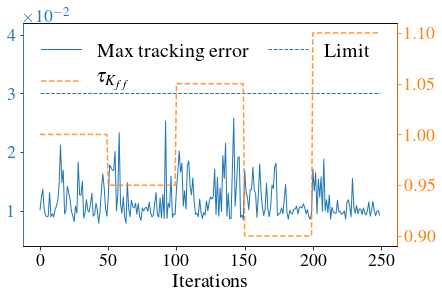

In [64]:
set_figure_params(fontsize=20)
legend_kwargs = dict(ncol=2, columnspacing=1.)

fig, (ax1, ax2), (l1, l2) = plot_with_task(np.arange(250), min_cost, 'tab:blue', 'Min cost', task, 'tab:orange', r'$\tau_{K_{ff}}$', lw1=lw)
l3 = ax1.plot(np.arange(250), cost, label='Cost', c='tab:blue', lw=0.5)
ax1.set_xlabel('Iterations')
ax1.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
ax1.set_ylim([0.001, 0.007])

unify_legend(ax1, l1+l2+l3, **legend_kwargs)
plt.tight_layout(pad=0.1)
plt.savefig(PLOTS_DIR.joinpath('cost.pdf'), format='pdf', transparent=True)


fig, (ax1, ax2), (l1, l2) = plot_with_task(np.arange(250), safety_const, 'tab:blue', 'Safety value', task, 'tab:orange', r'$\tau_{K_{ff}}$')
l3 = ax1.plot(np.full_like(safety_const, 600), '--', c='tab:blue', label='Limit', lw=1)
ax1.set_xlabel('Iterations')
ax1.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
ax1.set_ylim([270, 750])
unify_legend(ax1, l1+l2+l3, **legend_kwargs)
plt.tight_layout(pad=0.1)
plt.savefig(PLOTS_DIR.joinpath('safety_constraint.pdf'), format='pdf', transparent=True)

fig, (ax1, ax2), (l1, l2) = plot_with_task(np.arange(250), performance_const, 'tab:blue', 'Max tracking error', task, 'tab:orange', r'$\tau_{K_{ff}}$')
l3 = ax1.plot(np.full_like(safety_const, 0.03), '--', c='tab:blue', label='Limit', lw=1)
ax1.set_xlabel('Iterations')
ax1.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
ax1.set_ylim([0.004, 0.042])

unify_legend(ax1, l1+l2+l3, **legend_kwargs)
plt.tight_layout(pad=0.1)
plt.savefig(PLOTS_DIR.joinpath('performance_constraint.pdf'), format='pdf', transparent=True)

### Feed forward gain not modeled
Figure 7 in the paper.

In [65]:
PLOTS_DIR = Path("./KFF_exp_no_task_param/")
PLOTS_DIR.mkdir(exist_ok=True)

kff_mat = mat = scipy.io.loadmat(BASE_DIR.joinpath('NotaskKff_exp.mat'))
task, switches, cost, cost_per_task, min_cost, safety_const, performance_const = unpack_adaptive_exp(kff_mat)

In [66]:
set_figure_params(fontsize=20)
legend_kwargs = dict(ncol=2, columnspacing=1.)

fig, (ax1, ax2), (l1, l2) = plot_with_task(np.arange(250), min_cost, 'tab:blue', 'Min cost', task, 'tab:orange', r'$\tau_{K_{ff}}$', lw1=lw)
l3 = ax1.plot(np.arange(250), cost, label='Cost', c='tab:blue', lw=0.5)
ax1.set_xlabel('Iterations')
ax1.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
ax1.set_ylim([0.001, 0.007])

unify_legend(ax1, l1+l2+l3, **legend_kwargs)
plt.tight_layout(pad=0.1)
plt.savefig(PLOTS_DIR.joinpath('cost.pdf'), format='pdf', transparent=True)


fig, (ax1, ax2), (l1, l2) = plot_with_task(np.arange(250), safety_const, 'tab:blue', 'Safety value', task, 'tab:orange', r'$\tau_{K_{ff}}$')
l3 = ax1.plot(np.full_like(safety_const, 600), '--', c='tab:blue', label='Limit', lw=1)
ax1.set_xlabel('Iterations')
ax1.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
ax1.set_ylim([270, 750])
unify_legend(ax1, l1+l2+l3, **legend_kwargs)
plt.tight_layout(pad=0.1)
plt.savefig(PLOTS_DIR.joinpath('safety_constraint.pdf'), format='pdf', transparent=True)

fig, (ax1, ax2), (l1, l2) = plot_with_task(np.arange(250), performance_const, 'tab:blue', 'Max tracking error', task, 'tab:orange', r'$\tau_{K_{ff}}$')
l3 = ax1.plot(np.full_like(safety_const, 0.03), '--', c='tab:blue', label='Limit', lw=1)
ax1.set_xlabel('Iterations')
ax1.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
ax1.set_ylim([0.004, 0.042])

unify_legend(ax1, l1+l2+l3, **legend_kwargs)
plt.tight_layout(pad=0.1)
plt.savefig(PLOTS_DIR.joinpath('performance_constraint.pdf'), format='pdf', transparent=True)

### Moment of inertia
Figure 5 bottom in the paper.

In [213]:
PLOTS_DIR = Path("./B_exp/")
PLOTS_DIR.mkdir(exist_ok=True)

kff_mat = mat = scipy.io.loadmat(BASE_DIR.joinpath('Adaptb_exp.mat'))
task, switches, cost, cost_per_task, min_cost, safety_const, performance_const = unpack_adaptive_exp(kff_mat, increment=1.5)

/Users/matteoturchetta/anaconda/lib/python3.6/site-packages/scipy/io/matlab/mio.py:218: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


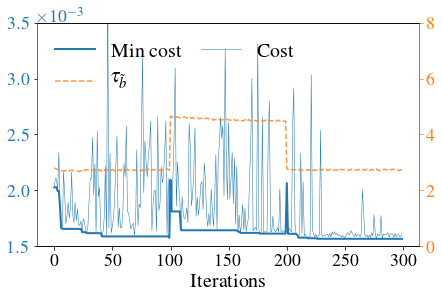

In [215]:
set_figure_params(fontsize=20)
legend_kwargs = dict(ncol=2, columnspacing=1.)

x = np.arange(cost.size)
fig, (ax1, ax2), (l1, l2) = plot_with_task(x, min_cost, 'tab:blue', 'Min cost', task, 'tab:orange', r'$\tau_{\tilde{b}}$', lw1=lw)
l3 = ax1.plot(x, cost, label='Cost', c='tab:blue', lw=0.5)
ax1.set_xlabel('Iterations')
ax1.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
ax1.set_ylim([0.0015, 0.0035])
ax2.set_ylim([0, 8])
unify_legend(ax1, l1+l2+l3, **legend_kwargs)
plt.tight_layout(pad=0.1)

plt.savefig(PLOTS_DIR.joinpath('cost.pdf'), format='pdf', transparent=True)


fig, (ax1, ax2), (l1, l2) = plot_with_task(x, safety_const, 'tab:blue', 'Safety value', task, 'tab:orange', r'$\tau_{\tilde{b}}$')
l3 = ax1.plot(np.full_like(safety_const, 600), '--', c='tab:blue', label='Limit', lw=1)
ax1.set_xlabel('Iterations')
ax1.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
ax1.set_ylim([260, 760])
ax2.set_ylim([0, 8])


unify_legend(ax1, l1+l2+l3, **legend_kwargs)
plt.tight_layout(pad=0.1)
plt.savefig(PLOTS_DIR.joinpath('safety_constraint.pdf'), format='pdf', transparent=True)

fig, (ax1, ax2), (l1, l2) = plot_with_task(x, performance_const, 'tab:blue', 'Max tracking error', task, 'tab:orange', r'$\tau_{\tilde{b}}$')
l3 = ax1.plot(np.full_like(safety_const, 0.03), '--', c='tab:blue', label='Limit', lw=1)
ax1.set_xlabel('Iterations')
ax1.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
ax1.set_ylim([0.005, 0.042])
ax2.set_ylim([0, 8])
unify_legend(ax1, l1+l2+l3, **legend_kwargs)
plt.tight_layout(pad=0.1)
plt.savefig(PLOTS_DIR.joinpath('performance_constraint.pdf'), format='pdf', transparent=True)